# 神经网络解决分类问题的基本流程

本节内容来自：[神经网络解决分类问题的基本流程](https://www.bilibili.com/video/BV1LT421v7Lw)

节选了一些我认为可以解决我的疑惑的内容。

## 为什么大家一开始采用 Sigmoid 作为激活函数？

Sigmoid 函数的公式为：
$
\sigma(x) = \frac{1}{1 + e^{-x}}
$

一开始，人们尝试模仿大脑中的神经元使用
$ f(x) =
\begin{cases}
1, x > 0 \\
0, x \leq 0
\end{cases}
$
作为激活函数，即有输入激活，没输入不激活（或者是达到一个阈值进行输出），但是在后面的发展中，发现这种方式效果并不好。
那为什么选用一个这么奇怪的函数作为激活函数呢？有什么数学原理或者细节呢？

实际上，这是为了采用逻辑回归的建模成果。

![](images/窗口效应和逻辑回归.png)

逻辑回归是解决分类问题的经典模型，比如对于一件商品，我们是否购买就分为了两类，因此我们就可以使用逻辑回归模型来预测我们是否购买这件商品。

在不可观察行为中，我们把是否购买的结果分解为正效应和负效应两个结果，实际上就是对应着不同两种决定因素，比如正效应就是我买了这个商品我可以获得良好的体验，负效应就是这件商品很贵。初次之外可能还有若干的正负效应叠加。

当正 > 负的时候，我们就认为用户产生购买行为，反之则不会购买。上图中，我们把正负效应使用线性模型回归（因为这是我们已知的最简单的模型），他们互相竞争的一个过程可以用上图中最下面的公式进行表示。该公式中包含正态分布的累计函数，但是我们无法知道 $F_{\epsilon}$ 确切的表示式子，于是我们只能去近似（为什么需要近似？当时的模型回归都是需要人来计算的，没有计算器所以尽可能需要用数学手段去近似它，在数值计算上可以减少计算量）。

对于 $F_{\epsilon}$ 的近似，我们发现，正态分布可以很好的用逻辑分布来近似，因此可以用逻辑分布来近似正态分布，这个逻辑分布就是 Sigmoid 。

并且，这一实现让神经元的输出有了概率的意义，借鉴上述的逻辑回归的过程，我们可以知道这样一个概率的背后是条件竞争产生的结果。
另外，Sigmoid 函数的值域范围在 (0, 1) ，一定程度上模拟了神经元的激活程度，比单纯的激活函数表示更丰富。

In [2]:
import torch

torch.manual_seed(1024)

In [3]:
### 手搓 Sigmoid

# 唐一旦老师这边想要去模仿 Pytorch 去实现一个线性的链接层，其中 self.weight 中的 in_features, out_features 实际上就是每个神经元的全连接

class Linear:
    # input: (B, in_features)
    # output: (B, out_features)

    def __init__(self, in_features, out_features, bias=True):
        """
        :param in_features: 输入神经元的个数
        :param out_features: 输出神经元的个数
        :param bias: 是否需要截距
        """
        # 对于模型参数的初始化，故意没有做优化
        self.weight = torch.randn(in_features, out_features, requires_grad=True)  # (in_features, out_features)
        if bias:
            self.bias = torch.randn(out_features, requires_grad=True)  # (             out_features)
        else:
            self.bias = None

    def __call__(self, x):
        # x:            (B, in_features)
        # self.weight:  (in_features, out_features)
        self.out = x @ self.weight  # (B, out_features)

        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        # 返回模型参数
        if self.bias is not None:
            return self.weight, self.bias
        return (self.weight,)


In [4]:
# 测试模型搭建是否符合预期
l = Linear(3, 4)
x = torch.randn(5, 3)
print(l(x).shape)
print(l.parameters())

torch.Size([5, 4])
(tensor([[-1.4837,  0.2671, -1.8337, -0.1047],
        [ 0.6002, -0.5496,  1.0391,  0.2261],
        [ 0.3490,  0.9540,  0.0909,  0.2139]], requires_grad=True), tensor([ 0.0137,  1.7289, -0.4150,  0.0753], requires_grad=True))


In [5]:
class Sigmoid:
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out

    def parameters(self):
        return tuple()

In [6]:
s = Sigmoid()
x = torch.randn(3, 2)
s(x).shape

torch.Size([3, 2])

In [7]:
class Perception:

    def __init__(self, in_features):
        self.ln = Linear(in_features, 1)
        self.f = Sigmoid()

    def __call__(self, x):
        # x: (B, in_features)
        self.out = self.f(self.ln(x))  # (B, 1)
        return self.out

    def parameters(self):
        return self.ln.parameters() + self.f.parameters()

In [8]:
p = Perception(3)
x = torch.randn(5, 3)
print(p(x).shape)

torch.Size([5, 1])


## Softmax 函数

$$
\mathbf{Z} = (z_0, z_1, \dots, z_{k-1}) => Softmax => \left( \frac{e^{z_0}}{\sum_{j=0}^{k-1} e^{z_j}}, \frac{e^{z_1}}{\sum_{j=0}^{k-1} e^{z_j}}, \dots, \frac{e^{z_{k-1}}}{\sum_{j=0}^{k-1} e^{z_j}} \right)
$$

In [9]:
class LogitRegression:
    # input: (B, in_features)
    # output: (B, 2)

    def __init__(self, in_features):
        self.pos = Linear(in_features, 1)
        self.neg = Linear(in_features, 1)

    def __call__(self, x):
        # x: (B, in_features)
        self.out = torch.concat([self.pos(x), self.neg(x)], dim=-1)  # (B, 2)
        return self.out

    def parameters(self):
        return self.pos.parameters() + self.neg.parameters()

In [10]:
lr = LogitRegression(3)
x = torch.randn(5, 3)
print(lr(x).shape)

torch.Size([5, 2])


In [11]:
import torch.nn.functional as F

logits = lr(x)
probs = F.softmax(logits, dim=-1)
print(probs)

# 每一行相加为 100%

tensor([[6.0937e-01, 3.9063e-01],
        [8.8799e-01, 1.1201e-01],
        [1.2545e-02, 9.8745e-01],
        [5.4686e-01, 4.5314e-01],
        [9.9931e-01, 6.9424e-04]], grad_fn=<SoftmaxBackward0>)


In [12]:
pred = torch.argmax(logits, dim=-1)  # 计算某一维度最节接近的结果
print(pred)

tensor([0, 0, 1, 0, 0])


In [13]:
print(logits, pred)
loss = F.cross_entropy(logits, pred)
print(loss)

tensor([[ 2.6585,  2.2138],
        [ 1.1108, -0.9596],
        [-3.1652,  1.2006],
        [-1.3272, -1.5151],
        [ 4.7086, -2.5634]], grad_fn=<CatBackward0>) tensor([0, 0, 1, 0, 0])
tensor(0.2462, grad_fn=<NllLossBackward0>)


In [14]:
# cross_entropy 等价于
print(-probs.log()[range(5), pred].mean())
# 把每一个预测的特征取对数，并把正确的预测结果相加求平均。
# 这里我想要讨论一下
# -probs.log()[range(5), pred] 与 -probs.log()[:, pred] 的区别
# -probs.log()[range(5), pred] 是对 (0, 1, 2, 3, 4) 这四行，每一行取第 pred 个数据
# -probs.log()[:, pred] 中代表的是 对于全部行的数据，取第 pred 个列组成一个新数据

tensor(0.2462, grad_fn=<NegBackward0>)


[[ 2.72662392  0.97448618]
 [-2.86541183  3.10777088]
 [-0.99719247  3.21520395]
 [-0.84641559  1.76552209]
 [ 1.45631298  4.08613823]
 [-2.28994486  4.74232574]
 [ 1.35751138  1.71506845]
 [ 1.70271437  1.71770465]
 [-1.73658497  3.24701379]
 [-2.10284821  1.27344947]
 [-1.95873861  2.50885771]
 [-1.16432603  2.62473339]
 [-1.08681167  0.75859495]
 [-1.60602147  0.98622737]
 [-2.16120058  1.5266393 ]
 [-0.81858045  1.23274886]
 [ 1.23688289  2.94784946]
 [ 2.11658054  1.67313667]
 [ 1.47309209  2.59013898]
 [-3.33255432  3.75079993]
 [ 2.10063843  3.11153915]
 [-2.73292419  2.29440933]
 [ 2.83503252  2.28912891]
 [ 2.06077841  0.64035506]
 [ 3.01433669  2.89233305]
 [-1.34199664  2.25506832]
 [-0.72741638  2.0260711 ]
 [ 1.74454272  2.90032646]
 [-2.45745011  2.03057777]
 [-2.96917294  3.69383725]
 [ 1.62810401  0.7509505 ]
 [-3.49172346  1.39242185]
 [ 1.41958216  1.28839776]
 [ 0.6823805   2.29244345]
 [ 3.54162986  0.12550742]
 [ 1.38834804  0.81803952]
 [ 2.81550256  3.94012539]
 

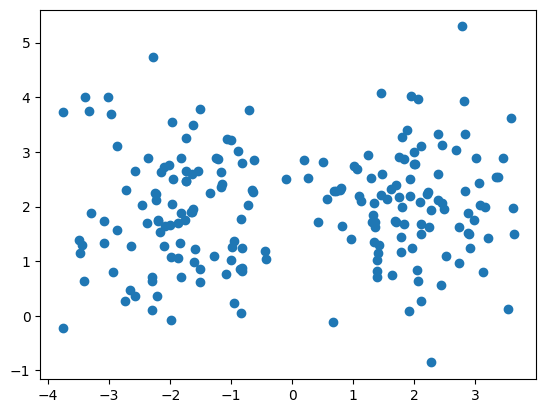

In [17]:
### 生成测试数据
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

data = make_blobs(200, centers=[[-2, 2], [2, 2]])
x, y = data

print(x, y)
plt.scatter(x[:, 0], x[:, 1])

In [24]:
batch_size = 20
max_steps = 2000
learning_rate = 0.01

"""
x坐标 ↘
        [2 * 1] → 正预测
        [2 * 1] → 负预测
y坐标 ↗
"""

lr = LogitRegression(2)
lossi = []

x, y = torch.tensor(x).float(), torch.tensor(y)

for t in range(max_steps):
    ix = (t * batch_size) % len(x)
    xx = x[ix: ix + batch_size]
    yy = y[ix: ix + batch_size]

    logits = lr(xx)
    loss = F.cross_entropy(logits, yy)
    loss.backward()

    with torch.no_grad():
        for p in lr.parameters():
            p -= learning_rate * p.grad
            p.grad = None

    if t % 200 == 0:
        print(f'step: {t}, loss: {loss.item()}')

    lossi.append(loss.item())



C:\Users\lovep\AppData\Local\Temp\ipykernel_41932\1388652094.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x).float(), torch.tensor(y)


step: 0, loss: 3.614760637283325
step: 200, loss: 0.170270174741745
step: 400, loss: 0.09395795315504074
step: 600, loss: 0.06800124049186707
step: 800, loss: 0.0543740876019001
step: 1000, loss: 0.04584439843893051
step: 1200, loss: 0.039956361055374146
step: 1400, loss: 0.03562803938984871
step: 1600, loss: 0.03230324015021324
step: 1800, loss: 0.02966490015387535


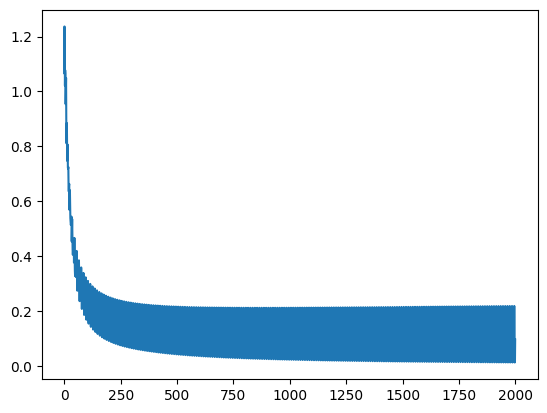

In [19]:
plt.plot(lossi)